In [5]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import DataLoader

from data_utils import save_model
from data_utils.BrainDataset import BrainDataset
from data_utils.BrainSampler import BrainSampler
from vae import VAE

In [6]:
training_params = {
    "batch_size" : 256,
    "batch_gpu" : 256,
    "train_time" : int(10e5),
    "tile_size" : 64,
    "training_brains" : ["B01", "B02", "B05", "B07"],
    "weighting": "by_pixel",
    "feature_space_dim": 128,
    "lr" : 1e-4,
    "wd" : 1e-6,
    "mse_weight" : 1,
    "KL_weight" : 3,
}
assert training_params["batch_size"] % training_params["batch_gpu"] == 0
torch.random.manual_seed(0)
data = BrainDataset(training_params["training_brains"])
sampler = BrainSampler(data, tile_size=training_params["tile_size"], weighting=training_params["weighting"])
loader = DataLoader(data, sampler=sampler, batch_size=training_params["batch_size"])

model = VAE(training_params["tile_size"], training_params["feature_space_dim"])
optimizer = torch.optim.Adam(model.parameters(), lr=training_params["lr"], weight_decay=training_params["wd"])
device = torch.device("cuda")
def loss_fn(recon_x, x, mu, log_sigma_sq):
    # MSE
    criterion = nn.MSELoss(reduction='sum')
    mse = criterion(recon_x, x)/training_params["batch_size"]
    
    # KL
    KL = -1/2 * torch.sum(1 + log_sigma_sq - log_sigma_sq.exp() - mu**2)/ training_params["batch_size"]
    return training_params["mse_weight"] * mse +  training_params["KL_weight"] * KL

In [7]:
def training_loop():
    losses = []
    model.train()
    model.to(device)
    total_batch_count = training_params["train_time"] // training_params["batch_size"]
    data_iter = iter(loader)
    pbar = tqdm(range(total_batch_count))
    for _ in pbar:
        batch_loss = 0
        optimizer.zero_grad()
        for _ in range(training_params["batch_size"] // training_params["batch_gpu"]):
            x = next(data_iter).to(device)
            recon_x, mu, sigma = model(x)
            batch_loss += loss_fn(recon_x, x, mu, sigma)
        batch_loss.backward()
        optimizer.step()
        pbar.set_description("Training loss: {:.4f}".format(batch_loss))
        losses.append(batch_loss.item())
    save_model(model, training_params)
    return losses

  0%|          | 0/3906 [00:00<?, ?it/s]

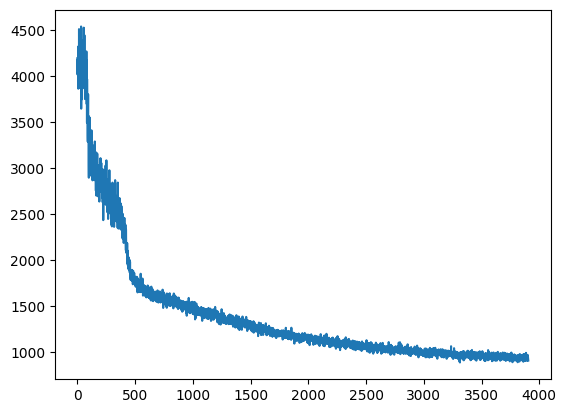

In [8]:
losses = training_loop()
plt.plot(losses)